# Benchmark Model Training
In this notebook we're training our benchmark model for bird classification using birdClef 2024's dataset.

## Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from utils import setup_plots, update_plots
from tqdm.notebook import tqdm

## Model Class
Just a basic convolutional neural network

In [6]:
# Input dimensions are 224x224

class BasicConvNet(nn.Module):
    def __init__(self, num_classes=12):
        super(BasicConvNet, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            # Block 1: 3 -> 64 channels
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112

            # Block 2: 64 -> 128 channels
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56

            # Block 3: 128 -> 256 channels
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56 -> 28x28

            # Block 4: 256 -> 512 channels
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )
        
        # Fully connected layer
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten 14x14x512 into a vector
            nn.Linear(512 * 14 * 14, 512),  # 14x14x512 = 100352 -> 512
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),  # Output logits for num_classes
        )

    def forward(self, x):
        x = self.features(x)  # Convolutional blocks
        x = self.classifier(x)  # Fully connected layers
        return x

## Dataset
Custom dataset class to easily load data from disk when training our model.

In [3]:
class SpectrogramDataset(Dataset):
    def __init__(self, path):
        self.path = path

        # Get all subdirectories (labels)
        self.classes = sorted(os.listdir(path))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Collect all image paths and corresponding labels
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(path, class_name)
            if (os.path.isdir(class_dir)):
                for img_name in os.listdir(class_dir):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # Load image
        img_path = self.images[index]
        label = self.labels[index]

        # Open and convert to RGB tensor
        image = Image.open(img_path).convert('RGB')
        image = pil_to_tensor(image)
        # Now image is 3 x 224 x 224

        return image, label

## Parameters & Object Declarations

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = BasicConvNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 250, 0.5) # Cut learning rate in half every 100 steps

In [5]:
dataset = SpectrogramDataset('processed_data/train_images')

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
len(train_loader)

1220

## Main Training Loop

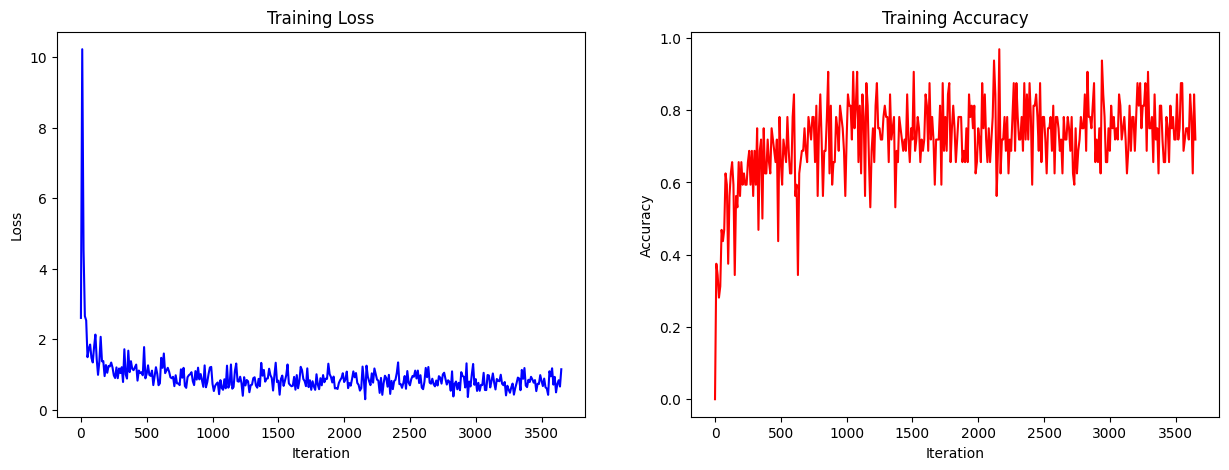

In [7]:
fig, ax1, ax2, loss_line, acc_line = setup_plots()
plt.close() # Close manual plot as automatic plot will display when calling update_plots(), prevents two sets of plots showing

losses = []
accuracies = []
iterations = []
max_epochs = 3
max_steps = 10000000
update_every = 10

# Training loop
model.train()
steps_passed = 0
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move data to device
        images = images.float().to(device)  # Convert to float
        labels = labels.to(device)
        
        # Forward and backward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Step scheduler
        scheduler.step()
        
        # Print every n steps
        if steps_passed % update_every == 0:
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Calculate accuracy
            total = labels.size(0)
            acc = (predicted == labels).float().mean()
            
            losses.append(loss.item())
            accuracies.append(acc.item())
            iterations.append(steps_passed)
            update_plots(losses, accuracies, iterations, fig, ax1, ax2, loss_line, acc_line)

        # increment total steps passed
        steps_passed += 1
        if steps_passed >= max_steps:
            break

## Validation Accuracy

In [8]:
accuracy_sum = 0
update_every = 10
model.eval()

with torch.no_grad(), tqdm(total=len(val_loader)) as pbar:
    for i, vdb_tensor in enumerate(val_loader):
        # Move data to device
        images = images.float().to(device)  # Convert to float
        labels = labels.to(device)

        outputs = model(images)
        
        # Calculate accuracy
        _, predictions = torch.max(outputs.data, 1)
        accuracy_sum += (predictions == labels).float().mean()

        if (i + 1) % update_every == 0 or (i + 1) == len(val_loader):
            current_mean = accuracy_sum / (i + 1)
            pbar.set_description(f'Validating (Acc: {current_mean:.3f})')
            pbar.update(update_every if i + 1 < len(val_loader) else len(val_loader) % update_every)

mean_accuracy = accuracy_sum/len(val_loader)
print(f'Final validation accuracy: {mean_accuracy:.3f}')

  0%|          | 0/305 [00:00<?, ?it/s]

Final validation accuracy: 0.846


In [10]:
model = torch.load('./model_3_epochs.pth')

/tmp/ipykernel_23266/3509306933.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./model_3_epochs.pth')


In [11]:
torch.save(model.state_dict(), 'model_epoch_3_state.pth')